# For this project, the goal was to correctly classify the state of water pumps in Tanzania, Africa.  The data was collected from the Tanzanian government and Tarrifa, an open source information collection platform.  The water pump are separated into three classes: Functional, Non-Functional, and Functional but needs repair.

In [1]:
#Libraries for data exploration and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#Imported the 3 csv files used in this project
test = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
features = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960.csv')
df = pd.read_csv('702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')
df = features.merge(test, on='id')
#There are a lot of redundant features in the data, removing them will help with dimensionality reduction
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [2]:
#Plotting Tanzania to see where in Africa it is and the landscape
from arcgis.gis import GIS
gis = GIS()
Tanzania = gis.map('Tanzania', 5)
Tanzania


MapView(layout=Layout(height='400px', width='100%'), zoom=5.0)

# Data analysis, Feature engineering, Feature extraction

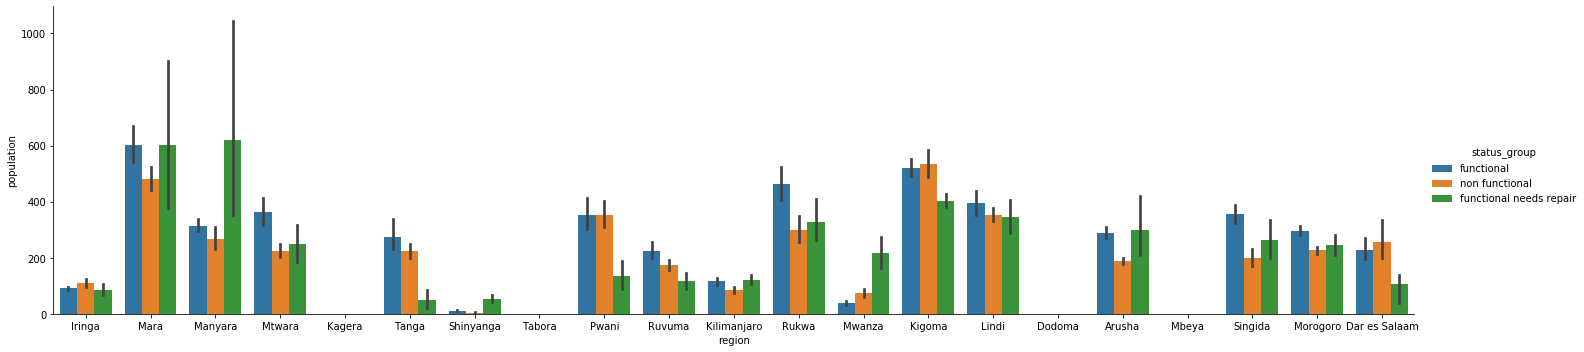

In [3]:
#Comparing region vs. population split between the 3 classes
#Tabora looks more remote than other places, that could be a reason for the lack of data
#But Dodoma looks like a major city, so maybe population or road conditions have an impact on the lack of data
#Mbeya looks more remote, same with Shinyanga
sns.catplot('region', 'population', data=df, hue='status_group', kind='bar', aspect=4)

In [4]:
#Checking the percentage of missing values for each feature - a feature selection technique
(df.isnull().sum()*100/ len(df)).sort_values(ascending=False)

scheme_name              47.417508
scheme_management         6.526936
installer                 6.153199
funder                    6.119529
public_meeting            5.612795
permit                    5.144781
subvillage                0.624579
ward                      0.000000
lga                       0.000000
district_code             0.000000
region_code               0.000000
region                    0.000000
num_private               0.000000
basin                     0.000000
wpt_name                  0.000000
latitude                  0.000000
longitude                 0.000000
gps_height                0.000000
date_recorded             0.000000
amount_tsh                0.000000
population                0.000000
status_group              0.000000
recorded_by               0.000000
water_quality             0.000000
waterpoint_type           0.000000
source_class              0.000000
source_type               0.000000
source                    0.000000
quantity_group      

In [5]:
#Checking the variance for each feature is also a feature selection technique - the more variance, the more that feature
#explains the dataset
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [6]:
#Checking the distribution between each of the target classes
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [7]:
#Transforming the date_recorded column into a datetime datatype
df['date_recorded'] = pd.to_datetime(df.date_recorded)

In [8]:
#Extracting only the year form that date
year_recorded = df.date_recorded.dt.year.values

In [9]:
year_recorded.dtype

dtype('int64')

In [10]:
#Making a new feature by subtracting the year it was last checked from the construction year
df['years_since_checked'] = year_recorded - pd.to_datetime(df['construction_year']).dt.year

In [11]:
df['years_since_checked'].value_counts()

41    28674
43    24271
42     6424
34       30
32        1
Name: years_since_checked, dtype: int64

In [12]:
#Re-checking the column names
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,years_since_checked
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,41
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,43
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,43
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,43
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,41


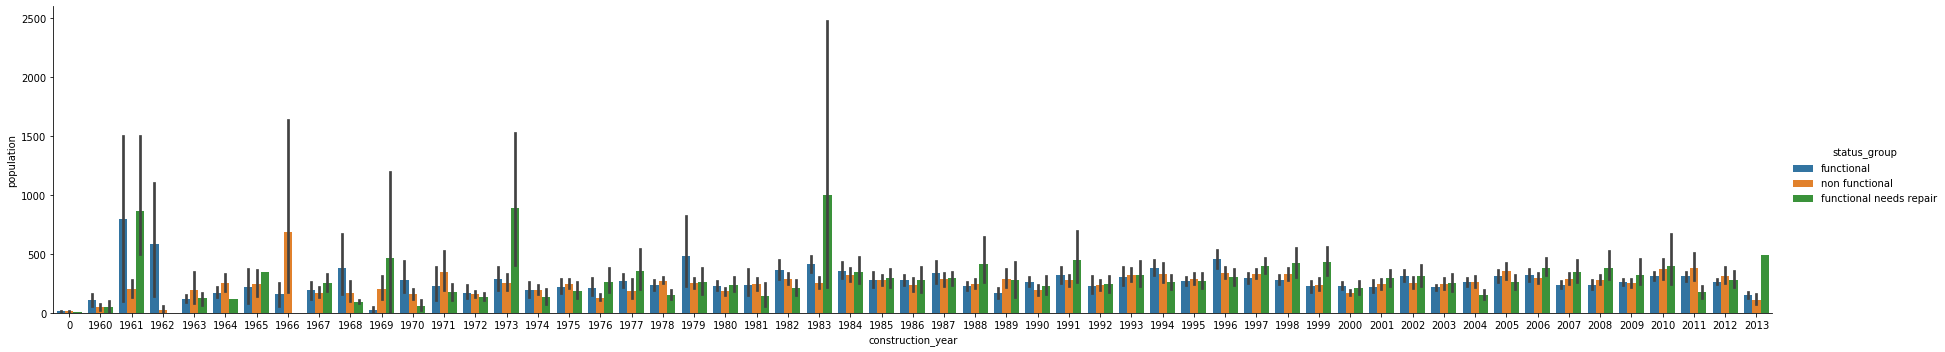

In [13]:
#Comparing construction_year vs. population split between the 3 classes
sns.catplot('construction_year', 'population', hue='status_group', data= df, kind='bar', aspect=5)

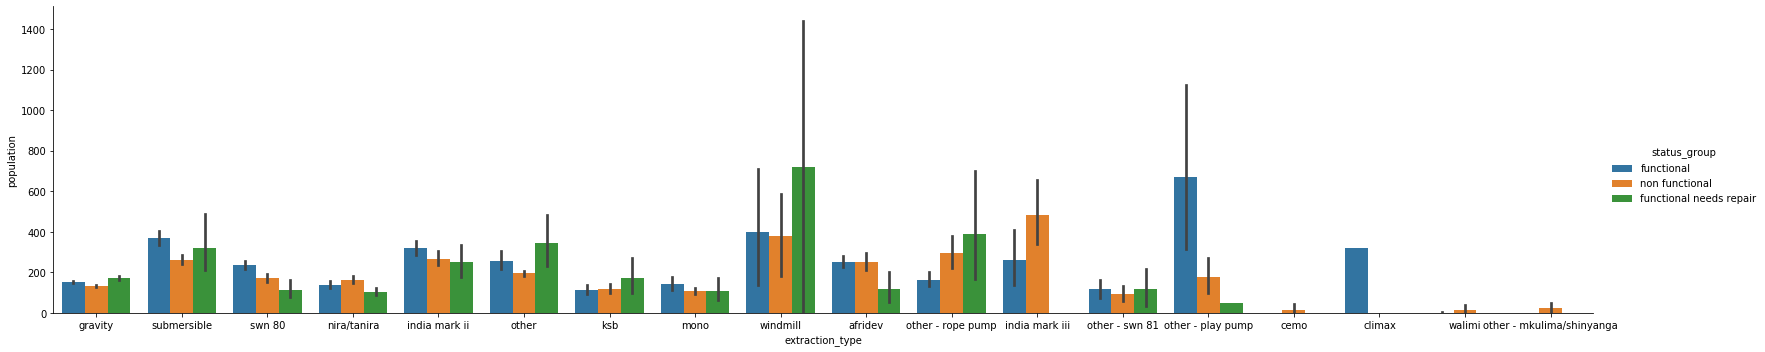

In [14]:
#Comparing extraction_type vs. population split between the 3 classes
sns.catplot('extraction_type', 'population', hue='status_group', data= df, kind='bar', aspect=4.5 )

In [15]:
#I didn't think these columns would be very useful so I dropped them
df.drop(['date_recorded','scheme_management','public_meeting','permit','subvillage','ward'],
        axis=1,inplace=True)

In [16]:
#Filling all null values of remaining columns with the foward fill method
df.fillna(method='ffill', inplace=True)

In [17]:
#Displaying column names so I could check for redundencies
df.columns

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'population', 'recorded_by', 'scheme_name',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'years_since_checked'],
      dtype='object')

In [18]:
#Here I am trying to get rid of some redundant features
#Comparing management and management_group
#I did not display the dataframe to save room
management = df[['management', 'management_group']]

In [19]:
#Comparing quantity and quantity_group
quanity = df[['quantity', 'quantity_group']]

In [20]:
#Comparing payment_type and payment
payment = df[['payment_type', 'payment']]

In [21]:
#Comparing source_type and source
source = df[['source', 'source_type']]

In [22]:
#Comparing water_quality and quality_group
quality = df[['water_quality', 'quality_group']]

In [23]:
#Comparing extraction_type, extraction_type_group, extraction_type_class, waterpoint_type, waterpoint_type_group
extraction = df[['extraction_type', 'extraction_type_group', 'extraction_type_class', 'waterpoint_type', 'waterpoint_type_group']]

In [24]:
df.shape

(59400, 36)

In [25]:
df.drop(['gps_height','management_group','id','wpt_name','num_private','region_code','quantity_group','payment_type',
        'district_code','lga','source_type','quality_group','extraction_type_group','extraction_type_class',
        'waterpoint_type_group','scheme_name','recorded_by'], axis=1, inplace=True)

In [26]:
df.shape

(59400, 19)

In [27]:
df.columns

Index(['amount_tsh', 'funder', 'installer', 'longitude', 'latitude', 'basin',
       'region', 'population', 'construction_year', 'extraction_type',
       'management', 'payment', 'water_quality', 'quantity', 'source',
       'source_class', 'waterpoint_type', 'status_group',
       'years_since_checked'],
      dtype='object')

In [28]:
# Add column named 'status_group_vals' to allow the use of a pivot table 

vals_to_replace = {'functional':2, 'functional needs repair':1,
                   'non functional':0}

df['status_group_vals']  = df.status_group.replace(vals_to_replace)

In [29]:
#Did not show pivot tables to save some room but the code is commented out at the bottom of each cell
management_vs_status = pd.pivot_table(df, index=['management', 'status_group'], values='status_group_vals', aggfunc='count')
#management_vs_status

In [30]:
basin_vs_status = pd.pivot_table(df, index=['basin', 'status_group'], values='status_group_vals', aggfunc='count')
#basin_vs_status

In [31]:
source_vs_status = pd.pivot_table(df, index=['source', 'status_group'], values='status_group_vals', aggfunc='count')
#source_vs_status

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 20 columns):
amount_tsh             59400 non-null float64
funder                 59400 non-null object
installer              59400 non-null object
longitude              59400 non-null float64
latitude               59400 non-null float64
basin                  59400 non-null object
region                 59400 non-null object
population             59400 non-null int64
construction_year      59400 non-null int64
extraction_type        59400 non-null object
management             59400 non-null object
payment                59400 non-null object
water_quality          59400 non-null object
quantity               59400 non-null object
source                 59400 non-null object
source_class           59400 non-null object
waterpoint_type        59400 non-null object
status_group           59400 non-null object
years_since_checked    59400 non-null int64
status_group_vals      59400 non-nul

In [33]:
#factorize all object datatypes machine learning algorithms
#Pd.factorize() - obtains numerical representation
df['funder'] = pd.factorize(df['funder'])[0]
df['installer'] = pd.factorize(df['installer'])[0]
df['extraction_type'] = pd.factorize(df['extraction_type'])[0]
df['management'] = pd.factorize(df['management'])[0]
df['payment'] = pd.factorize(df['payment'])[0]
df['water_quality'] = pd.factorize(df['water_quality'])[0]
df['quantity'] = pd.factorize(df['quantity'])[0]
df['status_group'] = pd.factorize(df['status_group'])[0]
df['basin'] = pd.factorize(df['basin'])[0]
df['region'] = pd.factorize(df['region'])[0]
df['source'] = pd.factorize(df['source'])[0]
df['source_class'] = pd.factorize(df['source_class'])[0]
df['waterpoint_type'] = pd.factorize(df['waterpoint_type'])[0]


# I did principal component analysis, although I think it was pointless because I already found all the features I wanted to use and reduced the dimensionality of the dataset.

In [34]:
df_X = df

In [35]:
#Performing Principal Component Analysis 
#Calculates data correlation matrix for original data
#Normalize each variable's mean
#dimensionality reduction
#PCA centers each data point to the orgin of a graph by subtracting the mean of each data point form the mean of the dataset.
#The new points are plotted and a line of best fit is drawn through those data points. 
#The residuals from the line to the data points are used to select features 
#or the data points are projected on to the line and the distances from those projected data point to the orgin are used.
from sklearn import decomposition
pca = decomposition.PCA()
pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [36]:
df_pca = pca.fit_transform(df_X)

In [37]:
pca.explained_variance_ratio_

array([8.75723445e-01, 8.96982455e-02, 1.98849381e-02, 1.15629571e-02,
       3.11935917e-03, 3.96845744e-06, 3.31891133e-06, 9.62777587e-07,
       7.55505079e-07, 5.30310363e-07, 4.10052536e-07, 3.63757141e-07,
       2.89945563e-07, 1.36224274e-07, 9.25602519e-08, 8.21341619e-08,
       6.38905014e-08, 6.03577322e-08, 1.09086035e-08, 9.16318986e-09])

In [38]:
pca = decomposition.PCA(n_components=20)
df_X_prime = pca.fit_transform(df_X)
df_X_prime.shape

(59400, 20)

In [39]:
#99% of the data is explained by the first 20 features
pca.explained_variance_ratio_.sum()

0.9999999999999997

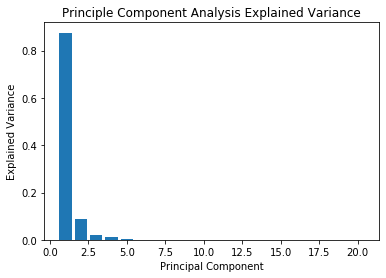

In [40]:
fig, ax = plt.subplots()
ax.bar(x=list(range(1, 21)), height=pca.explained_variance_ratio_)
ax.set_title("Principle Component Analysis Explained Variance")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Principal Component")
ax.xaxis.set_ticks = np.arange(20)
plt.show()

In [41]:
feature_names = list(df_X.columns.values)

In [42]:
feature_names[1]

'funder'

# Classification

In [43]:
#Splitting data into predictor and target variables
X = df.drop(['status_group', 'status_group_vals'], axis=1)
y = df.status_group

In [44]:
#Target classes
y.value_counts()

0    32259
1    22824
2     4317
Name: status_group, dtype: int64

In [45]:
import sklearn

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [48]:
#Scaling data to improve computing time
#Normalizes each feature to normal distribution - mu=0 and sigma = 1
from sklearn.preprocessing import StandardScaler
ss = StandardScaler(with_mean=True)
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

In [49]:
#Fitting data to a logistic regression model
#Logistic regression is a classification model
#I used class_weight='balanced' to balance out the 3 seprate classes
#When I added class_weight='balanced', my precision imporved
#With 'ovr' - onevsrest - a binary problem is fit for each class
#'saga' is used for larger datasets and can handle no penalty and multinominal loss(cross-entropy)
#Cross-entropy increases as the predicted probability moves away from actual label
#Cross-entropy calculates total entropy between the probability distributions(difference between the two distributions)
from sklearn.linear_model import LogisticRegression
logR = LogisticRegression(class_weight='balanced', random_state=0, solver='saga', multi_class='ovr' )

In [50]:
logR.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
predictions = logR.predict(X_test)

In [52]:
#0 - functional
#1- non-functional
#2 - functional but needs repair
#Comparing a test label and a predicted label
test.iloc[65]

id                       51072
status_group    non functional
Name: 65, dtype: object

In [53]:
predictions[65]

1

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.55      0.62      6457
           1       0.59      0.59      0.59      4572
           2       0.15      0.40      0.22       851

    accuracy                           0.56     11880
   macro avg       0.48      0.51      0.48     11880
weighted avg       0.62      0.56      0.58     11880



In [55]:
#Calculations for the output of first model but can be used for each model
#The same math can be applied for every model, this is just for logistic regression
#Functional precision - 3567/(3567 + 1163 + 296) - 0.709
#Functional recall - 3567/(3567 + 1639 + 1251) - 0.552
#Non - functional precision - 2699/(1639 + 2699 + 215) - 0.592
#Non - functional recall - 2699/(1163 + 2699 + 710) - 0.590
#Functional needs repair precision - 340/(1251 + 710 + 340) - 0.147
#Functional needs repair recall - 340/(296 + 215 + 340) - 0.399
#Accuracy - (3567 + 2699 +340)/(3567 + 1639 + 1251 + 1163 + 2699 + 710 + 296 + 215 + 340) - 0.556
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

[[3567 1639 1251]
 [1163 2699  710]
 [ 296  215  340]]


In [56]:
logR.score(X_test, y_test)

0.556060606060606

In [57]:
probs_y = logR.predict_proba(X_test)

In [58]:
#Probability of all predicted values being labeled correctly
probs_y

array([[0.18022129, 0.56187794, 0.25790078],
       [0.26959674, 0.47432235, 0.25608091],
       [0.50918492, 0.2124313 , 0.27838379],
       ...,
       [0.29851489, 0.37800433, 0.32348079],
       [0.39908148, 0.30140944, 0.29950908],
       [0.4754133 , 0.26984139, 0.2547453 ]])

# KNN

In [59]:
#K Nearest Neighbors
#P=2 - Euclidean distance formula
#N_neigbors = 2 gets the highest precision for correctly classifying non - functional which I think is most important to prevent
#sickness
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
clf = KNeighborsClassifier(n_neighbors=2, p=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [60]:
test_preds = clf.predict(X_test)

In [61]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.74      0.91      0.81      6457
           1       0.82      0.66      0.73      4572
           2       0.54      0.20      0.29       851

    accuracy                           0.76     11880
   macro avg       0.70      0.59      0.61     11880
weighted avg       0.76      0.76      0.74     11880



In [62]:
print(confusion_matrix(y_test, test_preds))

[[5848  500  109]
 [1533 3003   36]
 [ 533  151  167]]


In [63]:
accuracy_score(y_test, test_preds)

0.759090909090909

# Decision Tree Classifier

In [64]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

In [65]:
#Gini - measurement of inequility among values for each variable - the higher the gini score, the data is more dispearsed
#Entropy - measurement of uncertainty 
#RandomizedSearchCV- combinatorial grid search - with combinations order does not matter
#Parameters are not independent of eachother
#Combines cross validation with grid search of best parameters
#GridSearchCV - search over all specified parameter values

from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [3,5,7,20]}

In [66]:
gs_inst = GridSearchCV(dtc, param_grid=param_grid,cv=5)
gs_inst.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 20]},
             pre_dispat

In [67]:
from sklearn.metrics import accuracy_score
y_pred_gs = gs_inst.predict(X_test)
accuracy_score(y_test, y_pred_gs)

0.7018518518518518

In [68]:
gs_inst.best_params_

{'criterion': 'gini', 'max_depth': 20}

In [69]:
print(classification_report(y_test, y_pred_gs))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      6457
           1       0.72      0.68      0.70      4572
           2       0.28      0.27      0.27       851

    accuracy                           0.70     11880
   macro avg       0.58      0.57      0.58     11880
weighted avg       0.70      0.70      0.70     11880



In [70]:
print(confusion_matrix(y_test, y_pred_gs))

[[5018 1029  410]
 [1292 3093  187]
 [ 468  156  227]]


# AdaBoost Classifier

In [71]:
#Combines weak learners
#Each weak learner learns from the previous
#Learning rate - shrinks the contribution of each learner at each stage


from sklearn.ensemble import AdaBoostClassifier
param_dist = {'n_estimators': [50, 100],
             'learning_rate': [0.01,0.05,0.1,0.3,1]}

In [72]:
pre_gs_inst = RandomizedSearchCV(AdaBoostClassifier(),
                                param_distributions=param_dist,
                                cv=3,
                                n_iter= 10,
                                n_jobs=-1)

In [73]:
pre_gs_inst.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=None),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          1],
                                        'n_estimators': [50, 100]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [74]:
pre_gs_inst.best_params_

{'n_estimators': 100, 'learning_rate': 1}

In [75]:
#Create new randomized search based on the last one
param_grid = {'n_estimators': [100],
             'learning_rate': [0.04,0.045,0.05,0.055,0.06]}

In [76]:
pre2_gs_inst = RandomizedSearchCV(AdaBoostClassifier(),
                                param_distributions=param_grid,
                                cv=3,
                                n_iter= 10,
                                n_jobs=-1)

In [77]:
pre2_gs_inst.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=None),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.04, 0.045, 0.05,
                                                          0.055, 0.06],
                                        'n_estimators': [100]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [78]:
pre2_gs_inst.best_params_

{'n_estimators': 100, 'learning_rate': 0.06}

In [79]:
y_pred_gs2 =pre2_gs_inst.predict(X_test)
accuracy_score(y_test, y_pred_gs2)

0.6722222222222223

In [80]:
print(classification_report(y_test, y_pred_gs2))

              precision    recall  f1-score   support

           0       0.65      0.90      0.76      6457
           1       0.74      0.48      0.58      4572
           2       0.00      0.00      0.00       851

    accuracy                           0.67     11880
   macro avg       0.46      0.46      0.44     11880
weighted avg       0.64      0.67      0.63     11880



In [81]:
print(confusion_matrix(y_test, y_pred_gs2))

[[5808  649    0]
 [2394 2178    0]
 [ 722  129    0]]


# Stochastic Gradient Descent

In [82]:
#Precision of non-functional went up by 4% when using huber loss function
#Huber loss function - less sensitive to outliers
#Quadratic for small values and linear for large values

from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='huber')
sgd.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [83]:
accuracy_score(y_test, sgd.predict(X_test))

0.6279461279461279

In [84]:
print(classification_report(y_test, sgd.predict(X_test))) 

              precision    recall  f1-score   support

           0       0.61      0.89      0.73      6457
           1       0.68      0.37      0.48      4572
           2       0.00      0.00      0.00       851

    accuracy                           0.63     11880
   macro avg       0.43      0.42      0.40     11880
weighted avg       0.59      0.63      0.58     11880



In [85]:
print(confusion_matrix(y_test, sgd.predict(X_test)))

[[5761  696    0]
 [2873 1699    0]
 [ 737  114    0]]


# Naive Bayes

In [86]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB().fit(X_train, y_train)

In [87]:
nb.classes_

array([0, 1, 2], dtype=int64)

In [88]:
#Number of training samples in each class
nb.class_count_

array([25802., 18252.,  3466.])

In [89]:
accuracy_score(y_test, nb.predict(X_test))

0.5851010101010101

In [90]:
print(classification_report(y_test,  nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      0.72      0.67      6457
           1       0.53      0.50      0.51      4572
           2       0.25      0.01      0.02       851

    accuracy                           0.59     11880
   macro avg       0.47      0.41      0.40     11880
weighted avg       0.56      0.59      0.56     11880



In [91]:
print(confusion_matrix(y_test, nb.predict(X_test)))

[[4642 1799   16]
 [2259 2299   14]
 [ 577  264   10]]


LR: 0.633232 (0.004610)
KNN: 0.706263 (0.007318)
DTC: 0.752003 (0.006940)
ADA: 0.719613 (0.007927)
SGD: 0.532306 (0.030691)
NB: 0.587104 (0.006890)


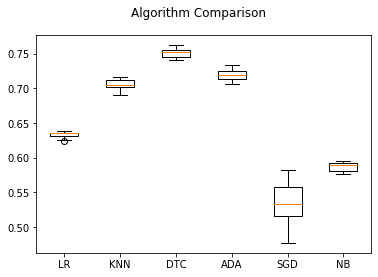

In [112]:
#Looking for high mean and low variance
#This contradicts some of the accuracy score we got above
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('SGD', SGDClassifier()))
models.append(('NB', BernoulliNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = sklearn.model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = sklearn.model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Deep Learning

In [93]:
#I thought I would try to implement a neural network although I do not know much about them at this point. I will have to do 
#some more research
#Alpha - regularization (L2)
#Shuffle - shuffles samples in each iteration
#At each step the partial derivative is taken for the loss function for each parameter to update the new parameters
#It did about as well as the knn model
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter = 1000, activation='logistic', alpha=0.001, learning_rate='adaptive', shuffle=True)

In [94]:
mlp.fit(X_train,y_train)

MLPClassifier(activation='logistic', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [95]:
 nn_preds = mlp.predict(X_test)

In [96]:
mlp.n_layers_

3

In [105]:
#Normale='False' - returns actual number of correctly classified pumps
print(accuracy_score(y_test, nn_preds, normalize=False))
print(accuracy_score(y_test, nn_preds))

8987
0.7564814814814815


In [98]:
print(classification_report(y_test,  mlp.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.85      0.81      6457
           1       0.76      0.73      0.74      4572
           2       0.55      0.20      0.29       851

    accuracy                           0.76     11880
   macro avg       0.69      0.59      0.61     11880
weighted avg       0.75      0.76      0.74     11880



# K-Nearest Neighbor performed the best with an accuracy score of 76%.  It also correctly classified non-functional pumps 82% of the time, which I think is the most important class in this problem.  Correctly classified non-functional pumps can increase maintenance response times, prevent illness, and prevent negative impact on the economy and environment. The multi-layer nueral network performed second best with 76% accuracy but only 76% precision for the non-functional pumps. However, when using a boxplot to compare my models, except for the nueral network, the decision tree and adaboost classifier had two of the highest mean values and lowest variances. I think more data is needed such as road conditions, events that are occuring at the time which may also affect accessibility and sensor data for the actual pump to improve the predictions.